In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
import os
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Demographic models

In [3]:
from demographicmodel import DemographicModel

In [4]:
data_dir = '../fastNeutrino/fitted_params/'
chroms = ['Chr2L', 'Chr2R', 'Chr3L', 'Chr3R']
t = np.logspace(1,7,100)


## Ragsdale and Gutenkunst

(200000.0, 4000000.0)

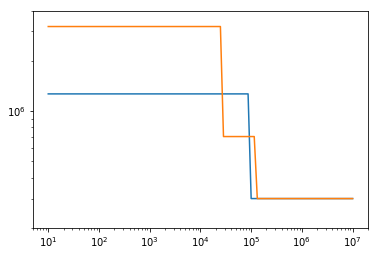

In [5]:
N_rg = 3e5

rg_model1 = DemographicModel()
rg_model1.add_epoch(0, N_rg*4.23, 0)
rg_model1.add_epoch(N_rg*0.329, N_rg, 0)

rg_model2 = DemographicModel()
rg_model2.add_epoch(0, N_rg*10.7, 0)
rg_model2.add_epoch(N_rg*0.0938, N_rg*2.35, 0)
rg_model2.add_epoch(N_rg*0.388, N_rg, 0)

plt.loglog(t, rg_model1.population_size(t))
plt.loglog(t, rg_model2.population_size(t))
plt.ylim([2e5,4e6])


## `fastneutrino` fits

In [6]:
model_types = ['2EpochConst', '2EpochExp', '3EpochConstConst', '3EpochExpConst', '3EpochConstExp', '3EpochExpExp']
models = {}
for mt in model_types:
    models[mt] = [DemographicModel(data_dir + chrom + '.' + mt + '.txt') for chrom in chroms]

/Users/dpr/mmc_genomics/src/demographicmodel.py:84: RuntimeWarning: overflow encountered in exp
  return n0*np.exp(-(T-t0)*r)


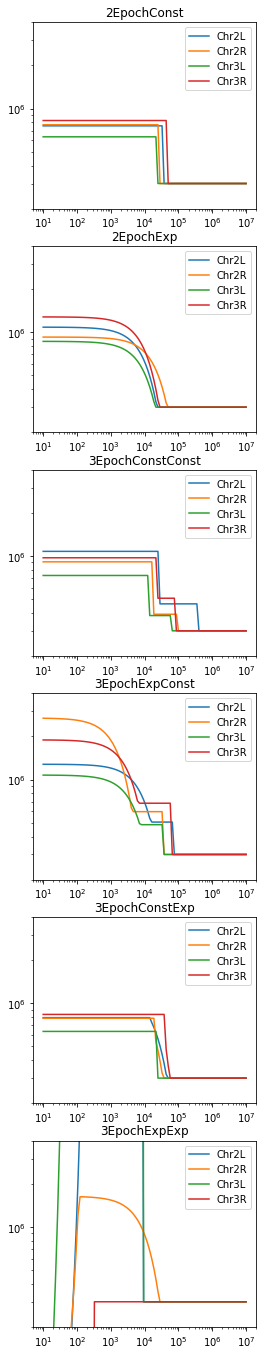

In [7]:
fig = plt.figure(figsize=(4,24))
for i, mt in enumerate(model_types):
    ax = fig.add_subplot(len(model_types), 1, i+1)
    for j, model in enumerate(models[mt]):
        ax.loglog(t, model.population_size(t), label=chroms[j])
    ax.set_title(mt)
    ax.set_ylim([2e5,4e6])
    plt.legend()


# Site frequency spectra

In [8]:
from helpers import get_sfs_from_fastNeutrino as get

In [9]:
sfs_fn = '../fastNeutrino/log/{}.{}.log'
sfs_dict = {mt:[get(sfs_fn.format(chrom, mt)) for chrom in chroms] for mt in model_types}

## Compare Expected vs. Observed SFS

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


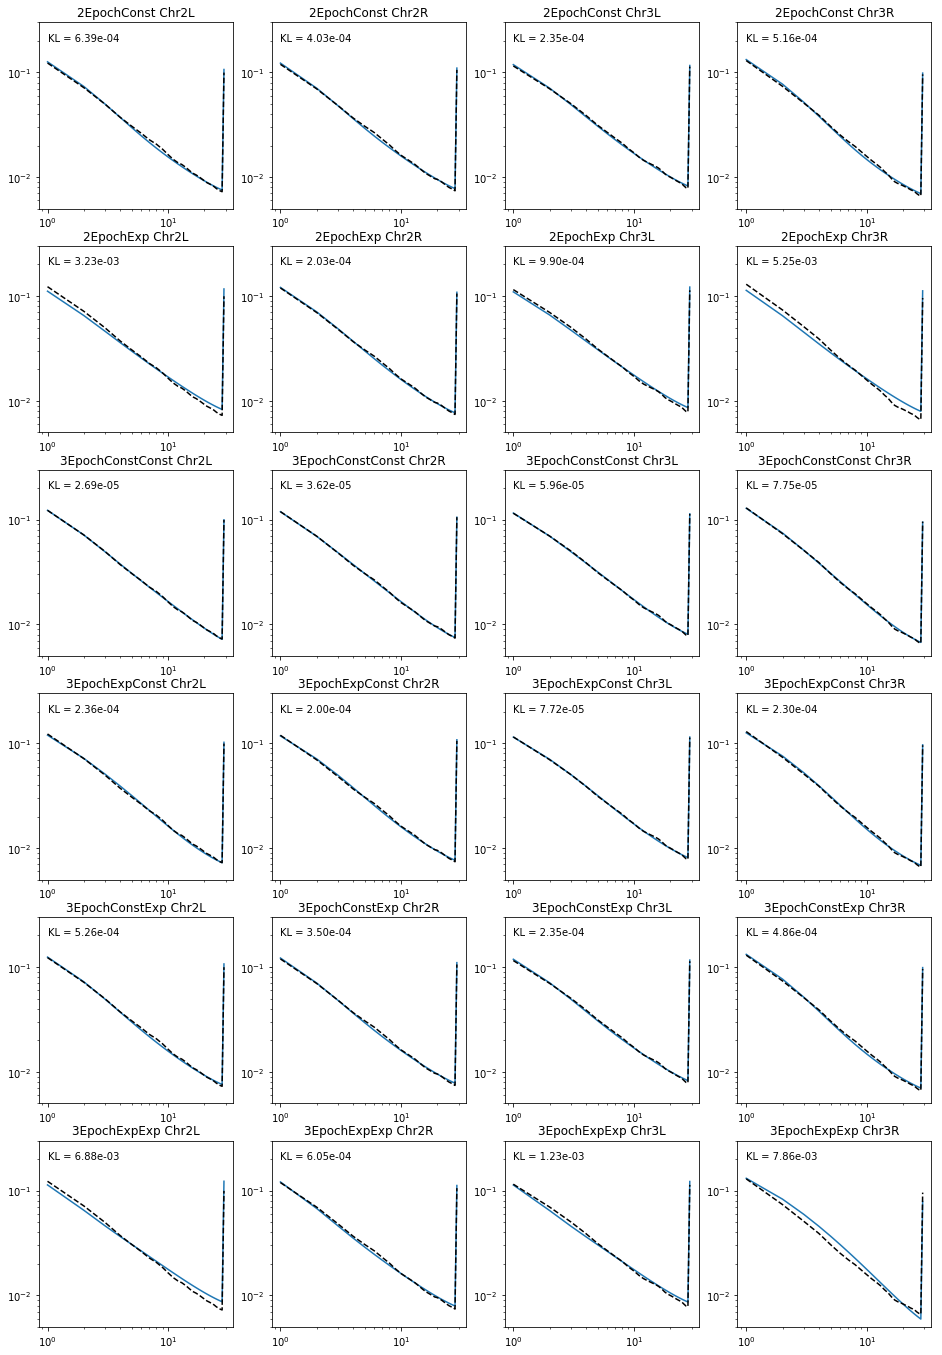

In [10]:
fig = plt.figure(figsize=(16,24))
for i, mt in enumerate(model_types):
    for j, sfs in enumerate(sfs_dict[mt]):
        ax = fig.add_subplot(len(model_types), len(chroms), (4*i)+j+1)
        ax.loglog(sfs[0])
        ax.loglog(sfs[1], 'k--')
        ax.set_title(mt + ' ' + chroms[j])
        ax.set_ylim([5e-3,3e-1])
        ax.text(1,0.2, 'KL = {0:.2e}'.format(float(sfs[2])))
    plt.legend()

## Relative error

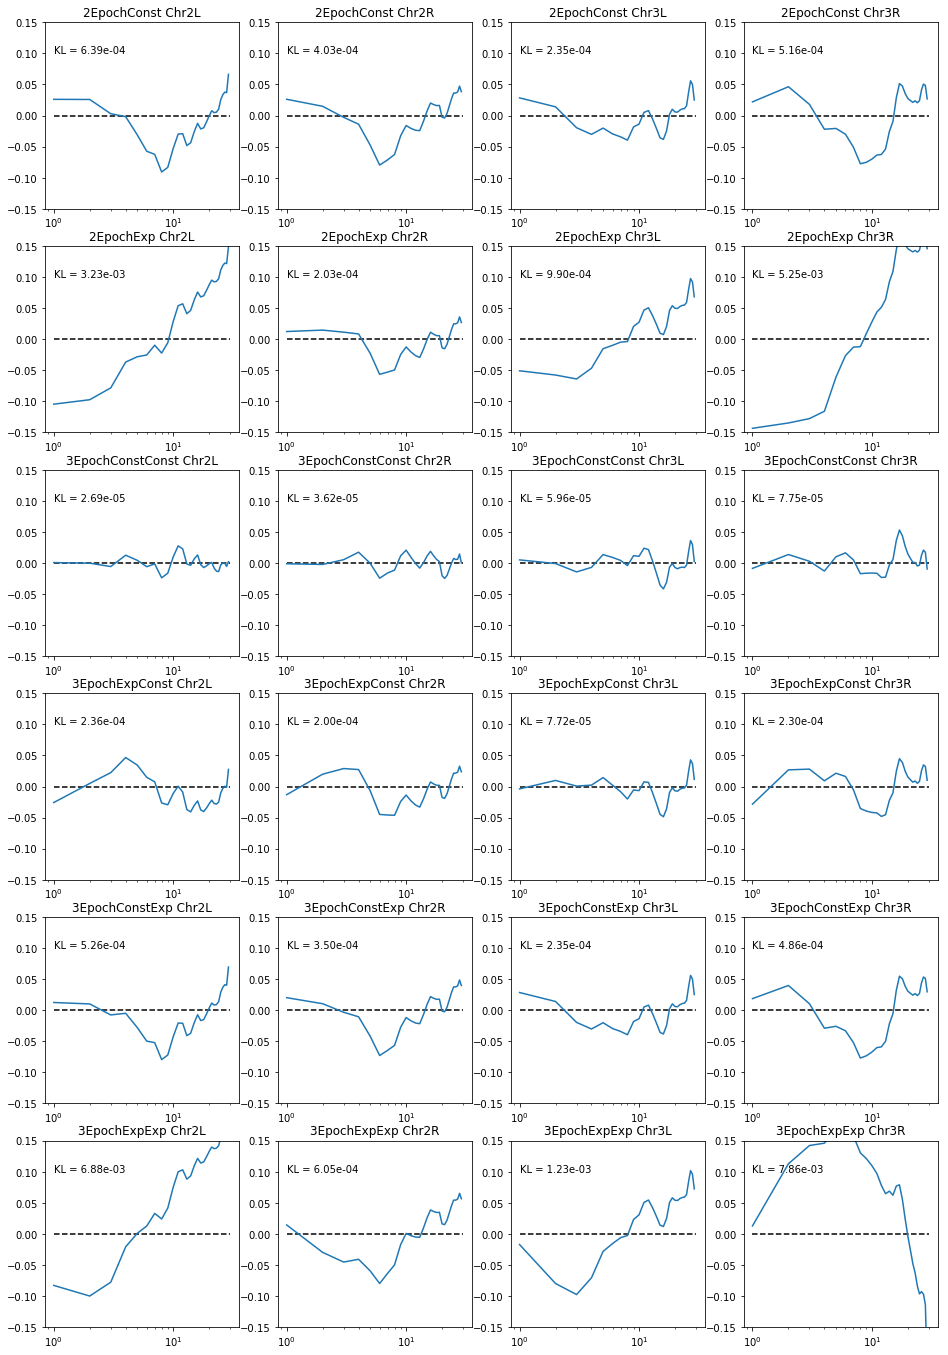

In [11]:
fig = plt.figure(figsize=(16,24))
for i, mt in enumerate(model_types):
    for j, sfs in enumerate(sfs_dict[mt]):
        ax = fig.add_subplot(len(model_types), len(chroms), (4*i)+j+1)
        ax.semilogx((sfs[0]-sfs[1])/sfs[0])
        ax.set_title(mt + ' ' + chroms[j])
        ax.set_ylim([-0.15,0.15])
        ax.hlines(0,1,30, linestyle='dashed')
        ax.text(1,0.1, 'KL = {0:.2e}'.format(float(sfs[2])))

## KL divergence

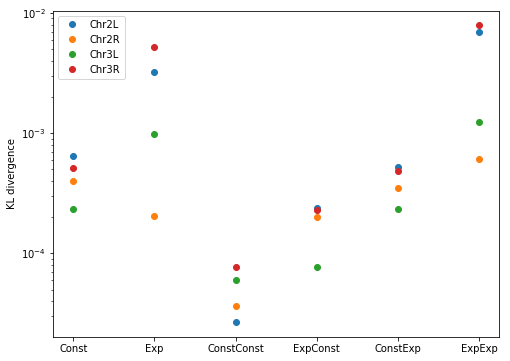

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i, mt in enumerate(model_types):
    for j, sfs in enumerate(sfs_dict[mt]):
        kl_div = float(sfs[2])
        l, = ax.plot(i, kl_div,'o', color='C{}'.format(j))
        if i == 0:
            l.set_label(chroms[j])
ax.set_yscale('log')
ax.set_xticks(np.arange(len(model_types)))
ax.set_xticklabels([mt.split('Epoch')[1] for mt in model_types])
ax.set_ylabel('KL divergence')
ax.legend()

# Renormalize models

`fastNeutrino` scales its models by the ancestral population size and gives time in generations. My `msprime` simulations set current population size to 1 and measure time in initial coalescence units. Here, we'll plot the models renormalized this way.

/Users/dpr/mmc_genomics/src/demographicmodel.py:84: RuntimeWarning: overflow encountered in exp
  return n0*np.exp(-(T-t0)*r)


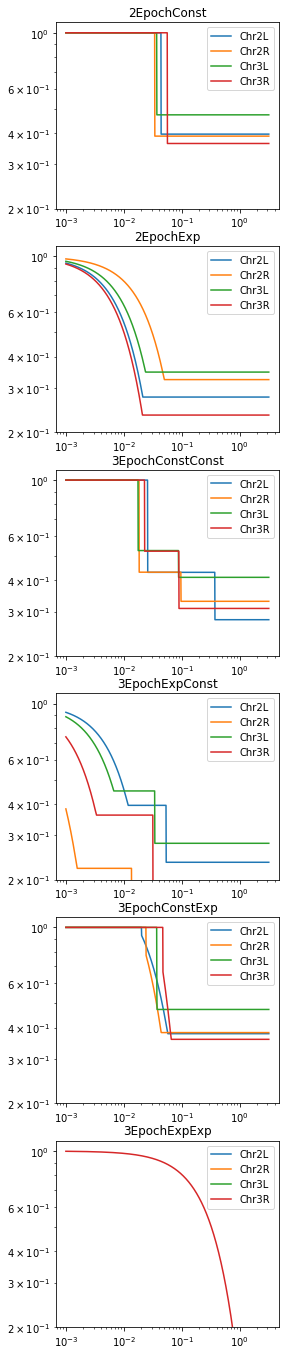

In [25]:
fig = plt.figure(figsize=(4,24))
t_rescale = np.logspace(-3,0.5,1000)
for i, mt in enumerate(model_types):
    ax = fig.add_subplot(len(model_types), 1, i+1)
    for j, model in enumerate(models[mt]):
        model.rescale()
        ax.loglog(t_rescale, model.population_size(t_rescale), label=chroms[j])
    ax.set_title(mt)
    ax.set_ylim([0.2,1.1])
    plt.legend()

# Conclusions

The 3-epoch piecewise constant model:
1. is by far the best fit to the SFS, and
2. has consistent $N(t)$ across chromosomes, especially when rescaled by $N(0)$.
Thus, I'm going to go with this one for further analysis.